 ## Detecting fake data

In [1]:
#pip install psycopg2

In [2]:

# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import psycopg2
from config import password 

param_dic = {
    "host"      : "localhost",
    "database"  : "HP_Homework",
    "user"      : "postgres",
    "password"  : password}

def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn






## Functions definition found at https://naysan.ca/2020/05/31/postgresql-to-pandas/

In [3]:
def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    

    tupples = cursor.fetchall()
    cursor.close()
    
 
    df = pd.DataFrame(tupples, columns=column_names)
    return df

In [4]:
# Connect to the database
conn = connect(param_dic)

salary_columns = ["emp_no", "salary"]
# Execute the "SELECT *" query
salaries = postgresql_to_dataframe(conn, "select * from salaries", salary_columns)
salaries.head()

Connecting to the PostgreSQL database...
Connection successful


,emp_no,salary
0,10001,60117
1,10002,65828
2,10003,40006
3,10004,40054
4,10005,78228


### Groupying by salaries helps to visualize the distribution of salaries

In [5]:
salaries_grouped=salaries.groupby('salary').count()
salaries_grouped

,emp_no
salary,
40000,95346
40001,5
40002,10
40003,9
40004,9
...,...
125469,1
126703,1
127041,1


### Let's check what's the min and max salary

In [6]:
max_salary=salaries['salary'].max()
min_salary=salaries['salary'].min()
print(max_salary,min_salary)

129492 40000


### Ploting a histagram to see the distribuition

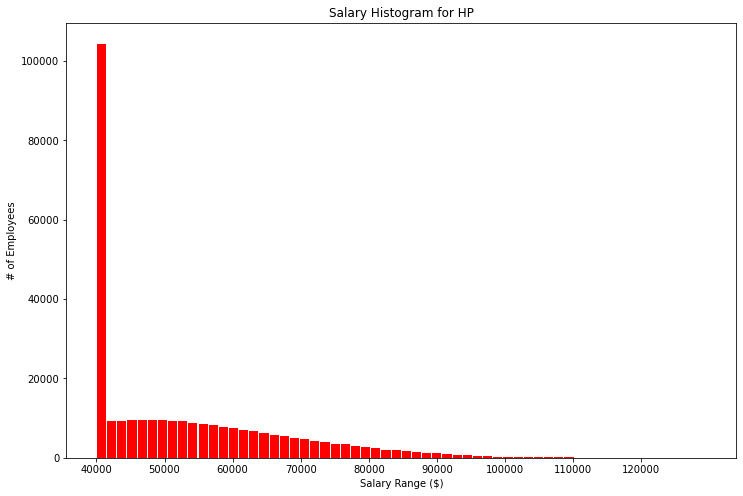

In [14]:
histogram = salaries.hist(column='salary', bins=60, grid=False, figsize=(12,8), color='r', zorder=2, rwidth=0.9)

x_ticks = np.arange(40000, 130000, 10000)
plt.xticks(x_ticks)
plt.xlabel('Salary Range ($)')
plt.ylabel('# of Employees')
plt.title('Salary Histogram for HP')
plt.savefig("salary_histogram.png")
plt.show()


#Clearly there's something abnormal about this distribution. More than 100K people have exactly the same salary, then, the second salary only differs by $1 or $2

## Understanding salaries per title

In [8]:
conn = connect(param_dic)

title_columns = ["title_id", "title"]
# Execute the "SELECT *" query
titles = postgresql_to_dataframe(conn, "select * from titles", title_columns)


Connecting to the PostgreSQL database...
Connection successful


In [9]:
conn = connect(param_dic)

employees_columns = ["emp_no", "emp_title_id", "birth_date", "first_name", "last_name", "sex", "hire_date"]
# Execute the "SELECT *" query
employees = postgresql_to_dataframe(conn, "select * from employees", employees_columns)

Connecting to the PostgreSQL database...
Connection successful


In [10]:
employees

,emp_no,emp_title_id,birth_date,first_name,last_name,sex,hire_date
0,473302,s0001,1953-07-25,Hideyuki,Zallocco,M,1990-04-28
1,475053,e0002,1954-11-18,Byong,Delgrande,F,1991-09-07
2,57444,e0002,1958-01-30,Berry,Babb,F,1992-03-21
3,421786,s0001,1957-09-28,Xiong,Verhoeff,M,1987-11-26
4,282238,e0003,1952-10-28,Abdelkader,Baumann,F,1991-01-18
...,...,...,...,...,...,...,...
300019,464231,s0001,1958-08-14,Constantino,Eastman,M,1988-10-28
300020,255832,e0002,1955-05-08,Yuping,Dayang,F,1995-02-26
300021,76671,s0001,1959-06-09,Ortrud,Plessier,M,1988-02-24
300022,264920,s0001,1959-09-22,Percy,Samarati,F,1994-09-08


In [11]:
employees=employees.rename(columns={'emp_title_id':'title_id'})

emp_titles=pd.merge(employees,titles, on='title_id' )
emp_titles_salary=pd.merge(emp_titles,salaries, on='emp_no')

title_salary=emp_titles_salary[['title','salary']]
grouped_title_salary=title_salary.groupby('title').mean()
grouped_title_salary

,salary
title,
Assistant Engineer,48564.434447
Engineer,48535.336511
Manager,51531.041667
Senior Engineer,48506.799871
Senior Staff,58550.172704
Staff,58465.382850
Technique Leader,48582.896092


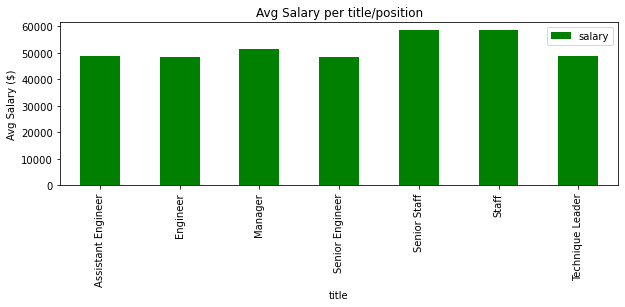

In [15]:
grouped_title_salary.plot(kind="bar", figsize=(10,3), color="g") #using pandas to plot a bar chart, green color.
plt.title("Avg Salary per title/position") #setting title for the plot
plt.ylabel('Avg Salary ($)')
plt.savefig("avg_salary_title.png")
plt.show()


#The average salary for staff and Sr Staff are higher than for any other position. The expectation would have been that Staff would have a lower salary compared to other positions. This confirms that the data is not accurate. 

## Looking for my ID

In [13]:
looking_my_id=employees.loc[employees['emp_no'] == 499942]
looking_my_id[['first_name','last_name']]

,first_name,last_name
168754,April,Foolsday


# I've been fooled !!